In [1]:
import keras
from src.utilities import load_data_as_set_of_particles
from src.Models.MLP import MLP
from src.Models.PointNet import PointNet
from src.Models.ParticleCloud import ParticleCloud
from src import utilities

#### Loading the Data

In [2]:
# Creating the trainning, validation and test set
X_train, y_train = load_data_as_set_of_particles("../Data/HiggsTrainning.csv")
X_val, y_val = load_data_as_set_of_particles("../Data/HiggsValidation.csv")
X_test, y_test = load_data_as_set_of_particles("../Data/HiggsTest.csv")

#### Defining the Model

In [3]:
# MLP for the PointNet
input_mlp_pn = keras.layers.Input(shape=[7])
mlp_pn = MLP(num_neurons=32)
mlp_pn_model = keras.Model(inputs=input_mlp_pn, outputs=mlp_pn(input_mlp_pn))

# MLP for the ParticleCloud
input_mlp_pc = keras.layers.Input(shape=[14])
mlp_pc = MLP(num_neurons=32)
mlp_pc_model = keras.Model(inputs=input_mlp_pc, outputs=mlp_pc(input_mlp_pc))

# input layer for the PointNet and ParticleCloud
input_layer = keras.layers.Input(shape=[6, 7])

# Defining the PointNet and ParticleCloud models
point_net = PointNet(mlp=mlp_pn_model, mlp_output_dim=32)(input_layer)
particle_cloud = ParticleCloud(mlp=mlp_pc_model, mlp_output_dim=32)(input_layer)
concatenated_models = keras.layers.Concatenate()([point_net, particle_cloud])

# addding more layers that receives the PointNet and ParticleCloud as inputs
hidden_layer = keras.layers.Dense(64, activation='relu')(concatenated_models)
dropout = keras.layers.Dropout(rate=0.1)(hidden_layer)
hidden_layer = keras.layers.Dense(64, activation='relu')(dropout)
dropout = keras.layers.Dropout(rate=0.1)(hidden_layer)
final_layer = keras.layers.Dense(2, activation='softmax')(dropout)

# Create the final model
model = keras.Model(inputs=input_layer, outputs=final_layer)

# Print the model summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 6, 7)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ point_net           │ (None, 64)        │      9,024 │ input_layer_2[0]… │
│ (PointNet)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ particle_cloud      │ (None, 64)        │      9,248 │ input_layer_2[0]… │
│ (ParticleCloud)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ point_net[0][0],  │
│ (Concatenate)       │                   │            │ particle_cloud[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │      4,160 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,818 (120.38 KB)

 Trainable params: 30,434 (118.88 KB)

 Non-trainable params: 384 (1.50 KB)

In [4]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5427 - loss: 0.6843 - val_accuracy: 0.6084 - val_loss: 0.6548
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6142 - loss: 0.6521 - val_accuracy: 0.6311 - val_loss: 0.6381
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6300 - loss: 0.6400 - val_accuracy: 0.6408 - val_loss: 0.6309
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6374 - loss: 0.6330 - val_accuracy: 0.6328 - val_loss: 0.6396
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6458 - loss: 0.6274 - val_accuracy: 0.6476 - val_loss: 0.6263
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6538 - loss: 0.6208 - val_accuracy: 0.6578 - val_loss: 0.6243
Epoch 7/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6497 - loss: 0.6240 - val_accuracy: 0.6596 - val_loss: 0.6142
Epoch 8/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6541 - loss: 0

#### Some Checks

In [5]:
# perfoming the prediction
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 448us/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


In [6]:
print("Trainnig set:")
utilities.display_metrics(y_true=y_train, y_pred=y_train_pred)
print("Validation set:")
utilities.display_metrics(y_true=y_val, y_pred=y_val_pred)
print("Test set:")
utilities.display_metrics(y_true=y_test, y_pred=y_test_pred)

Trainnig set:
Recall: 0.7496
Precision: 0.7210
Confusion Matrix:
[[20410  9800]
 [ 8461 25329]]
Validation set:
Recall: 0.7287
Precision: 0.6949
Confusion Matrix:
[[4857 2701]
 [2290 6152]]
Test set:
Recall: 0.7249
Precision: 0.6990
Confusion Matrix:
[[6090 3309]
 [2917 7685]]


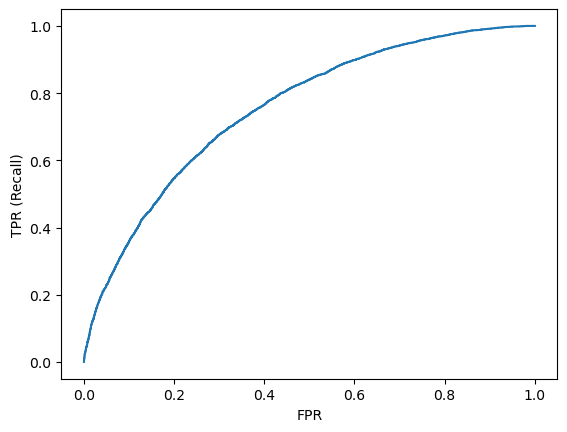

AUC: 0.7544


In [7]:
utilities.display_roc_curve(y_true=y_val, y_pred=y_val_pred)

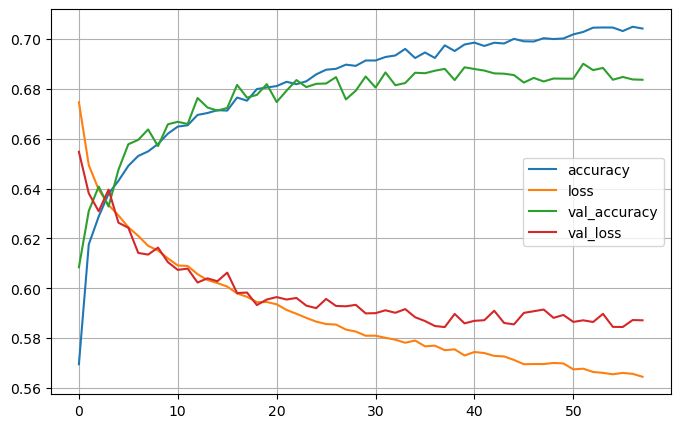

In [8]:
utilities.plot_hist_trainning(history)

In [9]:
utilities.save_model(model, history, "ModelFiles/CombinedModel")